In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-39f40fdc-b4e8-e700-68a2-57fd09606ab4)


## Download Dataset

In [ ]:
!curl 'https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/13836/1718836/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1610354456&Signature=ARSZJtI2bvPO4f5HTETnvav2WRQUa5qsaFRppmQmCyCDDXyGi%2FxSlOYuMjQlif%2Fpr4Wy9hOWKst1yGUwzrVrhxcvN2MNHe3KpfHHCrox7Hh5xO8INZpdUwHsb%2Bz6nESHou4LsjxHJMRE0FrIKCZ189MPQr3p%2BDpDCoQMhpQvUFW%2FrOHgknqnea6bJhY2hG4v8djSBaVXe4NqcS3I41z2yNB%2Fq3pL9H7%2B1t%2FJJqFPyspRnFnyqlTpjYKfzET3I1cvo3XNJMGHDEb1i3xOnpRmeMCnfYU8f1W6KMbnn4fvrQB1XiGvx2UugtVF8LpYEXOOblqfTmnHuu0nownWLOz2%2Fg%3D%3D&response-content-disposition=attachment%3B+filename%3Dcassava-leaf-disease-classification.zip' \
-o 'dataset.zip'

!unzip dataset.zip -d data
# Remove unused file
!rm -rf '/content/dataset.zip'
!rm -rf '/content/data/test_tfrecords'
!rm -rf '/content/data/train_tfrecords'

In [ ]:
# Create folder for each class
!mkdir '/content/data/train_images/Bacterial Blight'
!mkdir '/content/data/train_images/Brown Streak Disease'
!mkdir '/content/data/train_images/Green Mottle'
!mkdir '/content/data/train_images/Mosaic Disease'
!mkdir '/content/data/train_images/Healthy'

In [ ]:
# Move each image to folder class
import pandas as pd
import shutil

IMG_DIR = '/content/data/train_images/'

df = pd.read_csv('/content/data/train.csv')
df['path'] = IMG_DIR + df['image_id']
df.replace({'label':{0: "Bacterial Blight",
                     1: "Brown Streak Disease",
                     2: "Green Mottle",
                     3: "Mosaic Disease",
                     4: "Healthy"}}, inplace=True)

for idx, row in df.iterrows():
    try:
        shutil.move(row['path'], IMG_DIR+row['label'])
    except:
        pass

## Code

In [ ]:
!pip install tflite-model-maker

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tflite_model_maker as tfl
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

def set_seed(SEED):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

set_seed(2021)

IMG_DIR = '/content/data/train_images/'

In [ ]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 100 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
def plot_eval(model, test_data):
    plt.figure(figsize=(20, 20))
    predicts = model.predict_top_k(test_data)
    for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(25)):
        ax = plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image.numpy(), cmap=plt.cm.gray)

        predict_label = predicts[i][0][0]
        true_label = test_data.index_to_label[label.numpy()]
        color = get_label_color(predict_label,
                                test_data.index_to_label[label.numpy()])
        ax.xaxis.label.set_color(color)
        plt.title('True: %s' % true_label)
        plt.xlabel('Pred: %s' % predict_label)
    plt.show()

## Create Dataset

In [ ]:
data = tfl.ImageClassifierDataLoader.from_folder(IMG_DIR)
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

INFO:tensorflow:Load image with size: 21397, num_label: 5, labels: Bacterial Blight, Brown Streak Disease, Green Mottle, Healthy, Mosaic Disease.


## Base Model

Train Whole Model

In [ ]:
tf.keras.backend.clear_session()
base_mdl0 = tfl.image_classifier.create(train_data=train_data,
                                        model_spec='efficientnet_lite0',
                                        validation_data=validation_data,
                                        epochs=5,
                                        train_whole_model=True)

INFO:tensorflow:Retraining the models...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2 (HubKer (None, 1280)              3413024   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 3,419,429
Trainable params: 3,419,429
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5


534/534 [==============================] - 307s 564ms/step - loss: 1.0997 - accuracy: 0.6642 - val_loss: 0.8111 - val_accuracy: 0.7888
Epoch 2/5
534/534 [==============================] - 302s 566ms/step - loss: 0.8582 - accuracy: 0.7761 - val_loss: 0.7885 - val_accuracy: 0.8030
Epoch 3/5
534/534 [==============================] - 302s 566ms/step - loss: 0.7921 - accuracy: 0.8102 - val_loss: 0.7935 - val_accuracy: 0.8078
Epoch 4/5
534/534 [==============================] - 305s 571ms/step - loss: 0.7468 - accuracy: 0.8273 - val_loss: 0.7777 - val_accuracy: 0.8248
Epoch 5/5
534/534 [==============================] - 307s 576ms/step - loss: 0.7174 - accuracy: 0.8476 - val_loss: 0.7816 - val_accuracy: 0.8187


In [ ]:
tf.keras.backend.clear_session()
base_mdl1 = tfl.image_classifier.create(train_data=train_data,
                                        model_spec='efficientnet_lite1',
                                        validation_data=validation_data,
                                        epochs=5,
                                        train_whole_model=True)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2 (HubKer (None, 1280)              4189344   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 4,195,749
Trainable params: 4,195,749
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5


534/534 [==============================] - 334s 619ms/step - loss: 1.0640 - accuracy: 0.6867 - val_loss: 0.8277 - val_accuracy: 0.7789
Epoch 2/5
534/534 [==============================] - 319s 598ms/step - loss: 0.8296 - accuracy: 0.7894 - val_loss: 0.7928 - val_accuracy: 0.7988
Epoch 3/5
534/534 [==============================] - 322s 603ms/step - loss: 0.7708 - accuracy: 0.8167 - val_loss: 0.8394 - val_accuracy: 0.7917
Epoch 4/5
534/534 [==============================] - 324s 607ms/step - loss: 0.7331 - accuracy: 0.8365 - val_loss: 0.7797 - val_accuracy: 0.8101
Epoch 5/5
534/534 [==============================] - 329s 616ms/step - loss: 0.6958 - accuracy: 0.8570 - val_loss: 0.8177 - val_accuracy: 0.7898


In [ ]:
tf.keras.backend.clear_session()
base_mdl2 = tfl.image_classifier.create(train_data=train_data,
                                        model_spec='efficientnet_lite2',
                                        validation_data=validation_data,
                                        epochs=5,
                                        train_whole_model=True)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2 (HubKer (None, 1280)              4869168   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 4,875,573
Trainable params: 4,875,573
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5


534/534 [==============================] - 353s 652ms/step - loss: 1.0671 - accuracy: 0.6778 - val_loss: 0.7795 - val_accuracy: 0.8049
Epoch 2/5
534/534 [==============================] - 347s 650ms/step - loss: 0.8027 - accuracy: 0.8023 - val_loss: 0.7892 - val_accuracy: 0.8082
Epoch 3/5
534/534 [==============================] - 352s 659ms/step - loss: 0.7547 - accuracy: 0.8275 - val_loss: 0.7630 - val_accuracy: 0.8158
Epoch 4/5
534/534 [==============================] - 352s 660ms/step - loss: 0.7074 - accuracy: 0.8514 - val_loss: 0.7729 - val_accuracy: 0.8205
Epoch 5/5
534/534 [==============================] - 351s 658ms/step - loss: 0.6730 - accuracy: 0.8692 - val_loss: 0.7512 - val_accuracy: 0.8376


In [ ]:
tf.keras.backend.clear_session()
base_mdl3 = tfl.image_classifier.create(train_data=train_data,
                                        model_spec='efficientnet_lite3',
                                        validation_data=validation_data,
                                        epochs=5,
                                        train_whole_model=True)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2 (HubKer (None, 1280)              6992768   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 6,999,173
Trainable params: 6,999,173
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5


534/534 [==============================] - 416s 769ms/step - loss: 1.0557 - accuracy: 0.6843 - val_loss: 0.7803 - val_accuracy: 0.8101
Epoch 2/5
534/534 [==============================] - 410s 768ms/step - loss: 0.7856 - accuracy: 0.8092 - val_loss: 0.7500 - val_accuracy: 0.8324
Epoch 3/5
534/534 [==============================] - 408s 764ms/step - loss: 0.7270 - accuracy: 0.8391 - val_loss: 0.7427 - val_accuracy: 0.8385
Epoch 4/5
534/534 [==============================] - 411s 770ms/step - loss: 0.6961 - accuracy: 0.8550 - val_loss: 0.7158 - val_accuracy: 0.8423
Epoch 5/5
534/534 [==============================] - 409s 767ms/step - loss: 0.6643 - accuracy: 0.8743 - val_loss: 0.7145 - val_accuracy: 0.8456


In [ ]:
tf.keras.backend.clear_session()
base_mdl4 = tfl.image_classifier.create(train_data=train_data,
                                        model_spec='efficientnet_lite4',
                                        validation_data=validation_data,
                                        epochs=5,
                                        train_whole_model=True)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2 (HubKer (None, 1280)              11837936  
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 11,844,341
Trainable params: 11,844,341
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5


534/534 [==============================] - 598s 1s/step - loss: 1.0384 - accuracy: 0.6941 - val_loss: 0.7870 - val_accuracy: 0.8054
Epoch 2/5
534/534 [==============================] - 593s 1s/step - loss: 0.7558 - accuracy: 0.8275 - val_loss: 0.7641 - val_accuracy: 0.8248
Epoch 3/5
534/534 [==============================] - 591s 1s/step - loss: 0.7009 - accuracy: 0.8530 - val_loss: 0.6991 - val_accuracy: 0.8570
Epoch 4/5
534/534 [==============================] - 595s 1s/step - loss: 0.6645 - accuracy: 0.8720 - val_loss: 0.7204 - val_accuracy: 0.8433
Epoch 5/5
534/534 [==============================] - 592s 1s/step - loss: 0.6295 - accuracy: 0.8921 - val_loss: 0.7267 - val_accuracy: 0.8447


## Evaluate Base Model

In [ ]:
history_loss = {}
history_val_loss = {}
history_accuracy = {}
history_val_accuracy = {}

for i, m in enumerate(base_model):
    history_loss[i] = m.history.history['loss']
    history_val_loss[i] = m.history.history['val_loss']
    history_accuracy[i] = m.history.history['accuracy']
    history_val_accuracy[i] = m.history.history['val_accuracy']

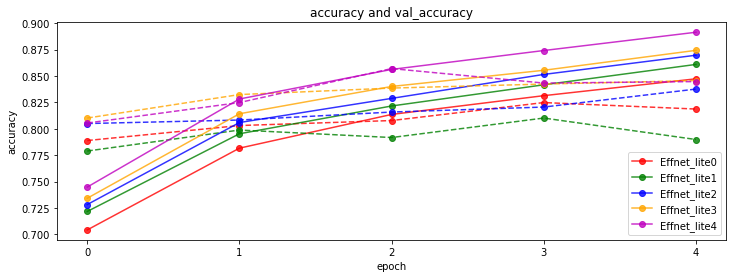

In [ ]:
epochs_range = range(5)
line_colors = ['r', 'g', 'b', 'orange', 'm']
plt.figure(figsize=(12, 4))
plt.title('accuracy and val_accuracy')
for i in range(5):
    plt.plot(epochs_range, history_accuracy[i], marker='o', label='Effnet_lite{}'.format(i), color=line_colors[i], alpha=0.8)
    plt.plot(epochs_range, history_val_accuracy[i], linestyle='--', marker='o', color=line_colors[i], alpha=0.8)
    plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()

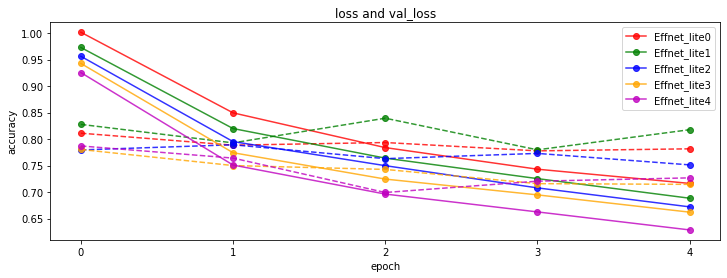

In [ ]:
epochs_range = range(5)
line_colors = ['r', 'g', 'b', 'orange', 'm']
plt.figure(figsize=(12, 4))
plt.title('loss and val_loss')
for i in range(5):
    plt.plot(epochs_range, history_loss[i], marker='o', label='Effnet_lite{}'.format(i), color=line_colors[i], alpha=0.8)
    plt.plot(epochs_range, history_val_loss[i], linestyle='--', marker='o', color=line_colors[i], alpha=0.8)
    plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()

In [ ]:
base_model = [base_mdl0, base_mdl1, base_mdl2, base_mdl3, base_mdl4]
base_loss = {}
base_accuracy = {}

for i, m in enumerate(base_model):
    print('Base Model {}'.format(i))
    loss, accuracy = m.evaluate(test_data)
    base_loss[i] = loss
    base_accuracy[i] = accuracy

Base Model 0
67/67 [==============================] - 63s 391ms/step - loss: 0.7801 - accuracy: 0.8131
Base Model 1
67/67 [==============================] - 63s 398ms/step - loss: 0.7878 - accuracy: 0.7963
Base Model 2
67/67 [==============================] - 63s 402ms/step - loss: 0.7500 - accuracy: 0.8294
Base Model 3
67/67 [==============================] - 64s 409ms/step - loss: 0.7282 - accuracy: 0.8388
Base Model 4
67/67 [==============================] - 64s 417ms/step - loss: 0.7205 - accuracy: 0.8379


## Export Base Model 3 (Efficientnet_lite3)

INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


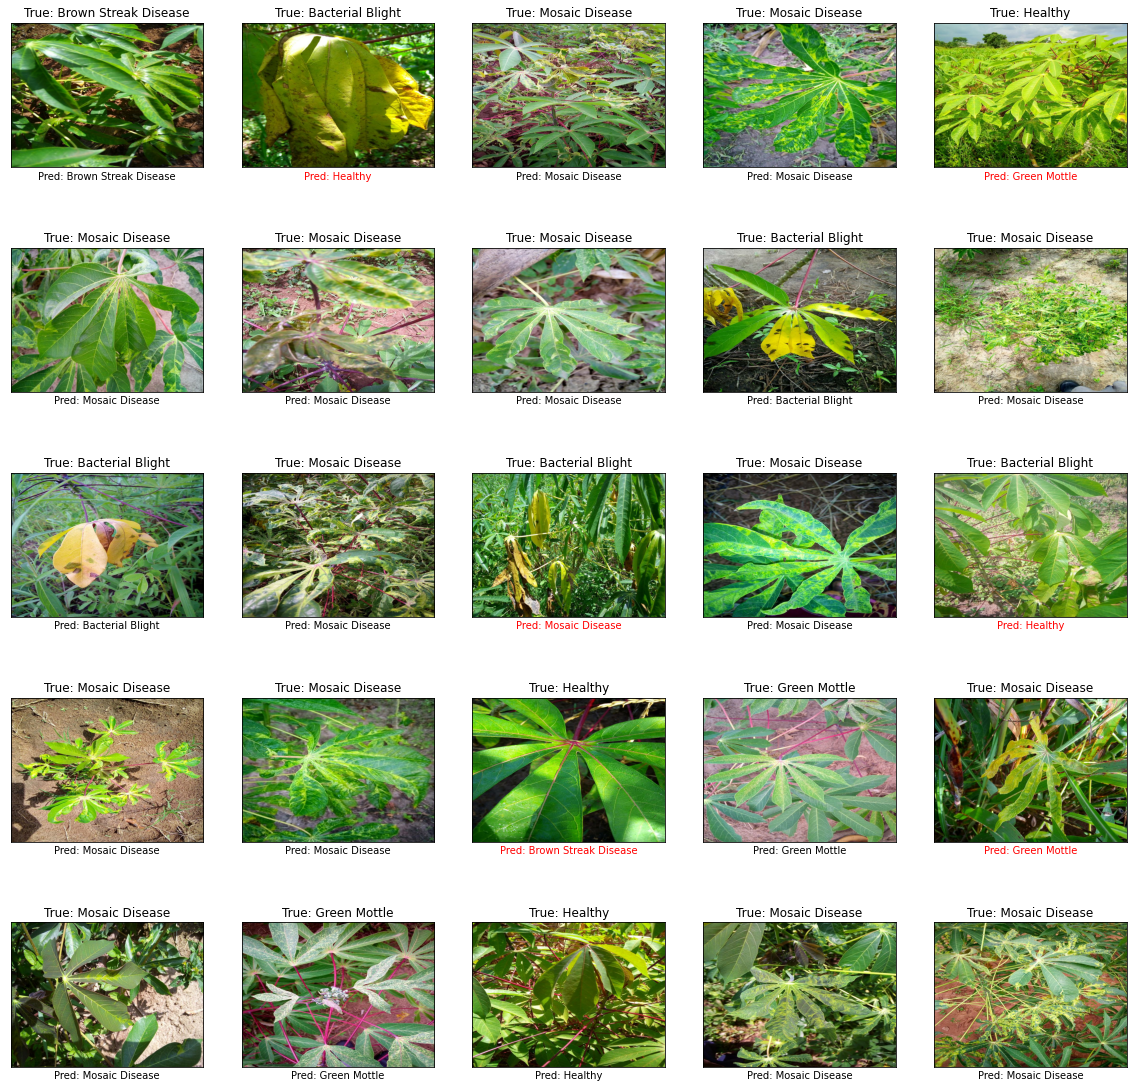

In [ ]:
plot_eval(base_mdl3, test_data)

In [ ]:
base_mdl3.export(export_dir='/content')

INFO:tensorflow:Assets written to: /tmp/tmp1kgjn15q/assets


INFO:tensorflow:Assets written to: /tmp/tmp1kgjn15q/assets


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmpju3wjlp4/labels.txt.


INFO:tensorflow:Saving labels in /tmp/tmpju3wjlp4/labels.txt.


In [ ]:
config = tfl.configs.QuantizationConfig.create_full_integer_quantization(representative_data=test_data, is_integer_only=True)
base_mdl3.export(export_dir='/content', tflite_filename='model_quant.tflite', quantization_config=config)

INFO:tensorflow:Assets written to: /tmp/tmpphhf3l3m/assets


INFO:tensorflow:Assets written to: /tmp/tmpphhf3l3m/assets


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmprs3r5w6p/labels.txt.


INFO:tensorflow:Saving labels in /tmp/tmprs3r5w6p/labels.txt.


## Move to fine tuning efficientnet_lite3 notebooks